### 1. Introduction
AirBnB is amongst the fastest growing technology disruptors that has disrupted traditional hotel and other mainstream accomodation by enabling individual home-owners to rent our their properties simply from a mobile app. Its the Uber of accomodation.

In short, a host downloads the mobile app, lists their property, decide on a price and the property becomes immediately available for rental to millions of potential stayers. AirBnB handles payments and a number of other logistics including security and verification.

The selection of a price by a host is subject to a number of micro- and socio-economic factors including demand, competition, geographic location, access to ammenities and others. The price is also the main factor a stayer uses to either stay at the next AirBnB or go to a hotel altogether.

We want to investigate AirBnB accomodation availability and pricing in Seattle and devise strategies to reduce prices for stayers. We will be using the CRISP-DM (Cross Industry Process for Data Mining) process which is a structured process for data science. This process has very specific steps we will be following throughout our investigation.

### 2. Business Understanding
The business questions we want answered are as follows:
- We will be travelling to Seattle for holiday and we have a number of things we need to know before departing. One of these is the status of accomodation.
- We plan to stay in an AirBnB, we need to know if we will actually find AirBnB accomodation.
- Is the AirBnB market growing to meet demand?
- What drives the prices of AirBnB rentals in Seattle?
- If we know what drives these prices, can we predict these prices?
- If prices have predictive properties, can we devise strategies to reduce them?
- Are these prices and demand cyclical?

### 3. Data Understanding
We review the characteristics of the data here. Fortunately for us AirBnB have already provided us with a dataset. We must just download and start getting initial insights from it.

AirBnB are providing us with a dataset that is broken into three components:
- calendar.csv: contains calendar information for the listed property for the given period (roughly a year in this case);
- listings.csv: contains the listings for the given period;
- reviews.csv: contains reviews provided by stayers for the given period.

First we load the required libraries and data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

calendar_df = pd.read_csv('./seattle/calendar.csv')
listings_df = pd.read_csv('./seattle/listings.csv')
reviews_df = pd.read_csv('./seattle/reviews.csv')

In [2]:
calendar_df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Number of rows and features in Calendar.

In [3]:
num_rows, num_features = calendar_df.shape
print('Calendar has {} rows and {} features.'.format(num_rows, num_features))

Calendar has 1393570 rows and 4 features.


In [4]:
calendar_df.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [5]:
max_date = pd.to_datetime(calendar_df['date'].max())
min_date = pd.to_datetime(calendar_df['date'].min())
print('Maximum date in calendar is: {}'.format(max_date))
print('Earliest date in calendar is: {}'.format(min_date))
print('Period covered is: {}'.format(max_date - min_date))

Maximum date in calendar is: 2017-01-02 00:00:00
Earliest date in calendar is: 2016-01-04 00:00:00
Period covered is: 364 days 00:00:00


In [6]:
set(calendar_df['available'])

{'f', 't'}

In [7]:
calendar_df.dtypes

listing_id     int64
date          object
available     object
price         object
dtype: object

These critical fields are mostly object types, we will need to fix these 
before we can do any detailed analysis. We will sort this out in the data preparation stage.

In [8]:
calendar_no_nulls = set(calendar_df.columns[calendar_df.isnull().mean() == 0])
print(calendar_no_nulls)
print('Listings Columns with no missing values: {}'.format(len(calendar_no_nulls)))

{'listing_id', 'available', 'date'}
Listings Columns with no missing values: 3


In [9]:
calendar_df.isnull().mean()

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

We see that nearly 33% of data is missing in the price column of the calendar.

Lets see where these missing are between the available and unavailable listings.

In [10]:
calendar_df_avail = calendar_df[calendar_df['available'] == 't']
calendar_df_non_avail = calendar_df[calendar_df['available'] == 'f']
print(len(calendar_df_avail), len(calendar_df_non_avail))

934542 459028


In [11]:
calendar_df_avail_nulls = set(calendar_df_avail.columns[calendar_df_avail.isnull().mean() == 0])
calendar_df_avail_nulls

{'available', 'date', 'listing_id', 'price'}

Since there are no missing values in the listings marked as available, we can conclude that the missing prices are all for unavailable properties. Which one could argue makes sense since there is little value in putting a price on a property which is not available anyways.

Lets fix the dates. We will need this when we look at the prices per month in the dataset.

In [101]:
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [102]:
calendar_df['year'] = calendar_df['date'].dt.year

In [104]:
calendar_df['month'] = calendar_df['date'].dt.month

In [106]:
calendar_df.dtypes

listing_id             int64
date          datetime64[ns]
available             object
price                 object
year                   int64
month                  int64
dtype: object

In [114]:
cal_df = calendar_df.copy()

In [115]:
cal_df.head()

,listing_id,date,available,price,year,month
0,241032,2016-01-04,t,$85.00,2016,1
1,241032,2016-01-05,t,$85.00,2016,1
2,241032,2016-01-06,f,NaN,2016,1
3,241032,2016-01-07,f,NaN,2016,1
4,241032,2016-01-08,f,NaN,2016,1


In [116]:
cal_df = cal_df.dropna(subset = ['price'], axis = 0)

In [119]:
cal_df['year'].value_counts()

2016    928844
2017      5698
Name: year, dtype: int64

In [163]:
len(listings_df.columns)

92

In [13]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [14]:
listings_df.shape

(3818, 92)

In [15]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [16]:
len(listings_df.columns)

92

In [17]:
set(listings_df.dtypes)

{dtype('int64'), dtype('float64'), dtype('O')}

## Categorical columns analysis
The below columns are categorical columns. We need to review them individually and keep only those we think are obvious candidates. We might remove some more columns if we decide that we are overfitting.

In [18]:
listings_df.select_dtypes(include = ['object']).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_s

In [19]:
cols_to_drop = ['listing_url', 'name', 'summary', 'experiences_offered','neighborhood_overview',
'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
'host_url', 'host_name', 'host_location', 'host_about', 'host_response_rate',
'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood','host_verifications',
'host_has_profile_pic', 'street', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
'market', 'smart_location', 'country_code','country','is_location_exact',
'has_availability', 'calendar_last_scraped', 'first_review','last_review',
'requires_license', 'jurisdiction_names', 'instant_bookable', 'require_guest_profile_picture',
'require_guest_phone_verification']

Columns that will likely be useful:
- host_since: perhaps the longer a person has been a host the more trust they inspire
- host_response_time: hosts who response quicker can charge a premium?
- host_is_superhost:
- host_identity_verified:
- neighourhood: some neighbourhoods should be able to charge more than others
- city: makes sense to analyze although I think neighbourhood might approximae city
- state: might determine prices somewhat
- zipcode: also geographical location based
- property_type
- room_type
- bed_type
- amenities
- price: this is our response variable, will need to be converted to float
- weekly_price: 47% missing data mean can be used
- montlhy_price: 60% missing data, can be dropped 
- security_deposit: 51% missing data, mean can be used
- cleaning_fee: 27% missing data
- extra_people
- calendar_update: 34 unique entries in column, its categoricalish
- cancellation_policy

## Numerical columns analysis
The following are numerical columns but not all of them are useful for our analysis here. For example, identifiers such as listing_id are unlikely to be useful for predicting price.

In [20]:
listings_df.select_dtypes(include = ['int64', 'float64']).columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [21]:
cols_to_drop = ['id', 'scrape_id', 'host_id', 'host_total_listings_count',
               'latitude', 'longitude', 'square_feet', 'guests_included',
                'minimum_nights', 'maximum_nights', 'availability_30',
                'availability_60', 'availability_90', 'availability_365', 
                'review_scores_accuracy', 'review_scores_cleanliness', 
                'review_scores_checkin',
                'review_scores_communication', 'review_scores_location',
                'review_scores_value', 'license', 'calculated_host_listings_count',
                'reviews_per_month']

Numerical columns that will be likely useful:
- host_listings_count:
- accomodates:
- bathrooms:
- bedrooms:
- beds:
- review_scores_rating

## Listings columns with no missing values
Some of these columns have already earmarked for deletion.

In [22]:
listings_no_nulls = set(listings_df.columns[listings_df.isnull().mean() == 0])
print(listings_no_nulls)
print('Listings Columns with no missing values: {}'.format(len(listings_no_nulls)))

{'availability_60', 'state', 'require_guest_phone_verification', 'availability_90', 'smart_location', 'description', 'city', 'has_availability', 'room_type', 'neighbourhood_group_cleansed', 'instant_bookable', 'accommodates', 'last_scraped', 'latitude', 'host_url', 'extra_people', 'scrape_id', 'host_verifications', 'availability_30', 'cancellation_policy', 'listing_url', 'host_id', 'amenities', 'calendar_updated', 'maximum_nights', 'picture_url', 'minimum_nights', 'number_of_reviews', 'availability_365', 'neighbourhood_cleansed', 'requires_license', 'name', 'country', 'calendar_last_scraped', 'street', 'longitude', 'country_code', 'bed_type', 'is_location_exact', 'market', 'require_guest_profile_picture', 'jurisdiction_names', 'experiences_offered', 'id', 'price', 'guests_included', 'calculated_host_listings_count'}
Listings Columns with no missing values: 47


## Listings columns with more than 75% missing values

In [23]:
listings_most_missing_cols = set(listings_df.columns[listings_df.isnull().mean() >= 0.75])
print(listings_most_missing_cols)

{'license', 'square_feet'}


These 2 columns are already identified above for deletion. Square_feet is missing 75% of the data.

## Room type will probably be interesting, lets see the values in the dataset

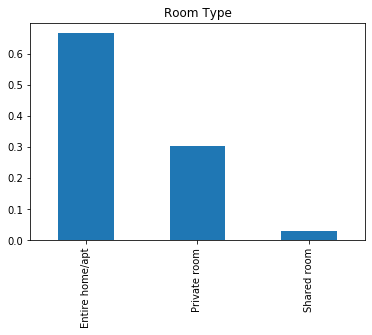

In [24]:
room_type_vals = listings_df.room_type.value_counts()
(room_type_vals/listings_df.shape[0]).plot(kind='bar')
plt.title('Room Type');

The majority of listings (about 70%) are entire homes or appartments. These probably drive the market.

## The number of bedroom should drive the price. Lets have a look at the distribution of beds in our dataset.

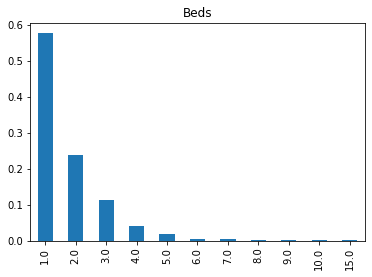

In [25]:
beds_vals = listings_df.beds.value_counts()
(beds_vals/listings_df.shape[0]).plot(kind='bar')
plt.title('Beds');

The majority of the listings have 1 bed followed by 2 and 3 beds. We will by how much an additional bed makes a listing more expensive.

### 4. Data Preparation
The first thing we do is merge our calendar and listings datasets. We leave out reviews for now as we already have some useful review information in the listings data.

In [26]:
def merge_and_drop(calendar_data, listings_data):
    """
    Merges calendar and listings and drops the columns we have initially
    identified as not usefull.
    INPUT
    ====================================================================
    calendar_df - pandas dataframe with calendar data
    listings_df - pandas dataframe with listings data
    
    OUTPUT
    ====================================================================
    df - pandas dataframe with merged calendar and listings dataframes and 
    identified categorial and numerical columns dropped.
    """
    
    # The categorical columns to be dropped.
    cat_cols_to_drop = ['listing_url','date','available','last_scraped', 'host_since', 'name', 'space','description', 'summary', 'experiences_offered','neighborhood_overview', 'notes', 
                        'transit', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 
                        'host_name', 'host_location', 'host_about', 'host_response_rate', 'host_thumbnail_url', 
                        'host_picture_url','neighbourhood', 'host_neighbourhood','host_verifications', 'host_has_profile_pic', 
                        'street', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'market', 'smart_location', 
                        'country_code','calendar_updated', 'country','is_location_exact', 'has_availability', 'calendar_last_scraped', 
                        'first_review','last_review', 'requires_license', 'jurisdiction_names', 'instant_bookable', 
                        'require_guest_profile_picture','amenities', 'require_guest_phone_verification',
                       'weekly_price', 'monthly_price', 'security_deposit']
    
    # The numeral columns to be dropped
    num_cols_to_drop = ['listing_id', 'scrape_id', 'host_id', 'host_total_listings_count', 'latitude', 'longitude', 'square_feet', 
                        'guests_included', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 
                        'availability_90', 'availability_365', 'review_scores_accuracy', 'review_scores_cleanliness', 
                        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'state', 'zipcode', 
                        'review_scores_value', 'license', 'calculated_host_listings_count', 'reviews_per_month']
    
    cols_to_drop = cat_cols_to_drop + num_cols_to_drop
    
    # Rename the listing_id column in listings_data so that we can use that to merge the two datasets
    calendar_data = calendar_data.rename(index = str, columns = {'price':'price_calendar'})
    listings_data = listings_data.rename(index = str, columns = {'id':'listing_id', 'price':'price_listing'})
    
    # Merge calendar and listings
    df = pd.merge(calendar_data, listings_data)
    
    df = df.drop(columns = ['price_calendar'], axis = 1)
    df = df.rename(index = str, columns = {'price_listing':'price'})
    
    # drop columns
    df = df.drop(columns = cols_to_drop, axis = 1)
    
    return df

df = merge_and_drop(calendar_df, listings_df)

In [27]:
df.columns

Index(['host_response_time', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_identity_verified', 'city',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'cleaning_fee', 'extra_people',
       'number_of_reviews', 'review_scores_rating', 'cancellation_policy'],
      dtype='object')

We now clean up the data here.

In [28]:
def clean_data(df):
    """
    INPUT
    ===================================================================
    df - pandas dataframe with all our data
    OUTPUT
    ===================================================================
    X - A matrix containing all of the variables to be used for predictiions.
    y - The respondent variable vector
    
    This function cleans df using the following steps to produce X and y:
    1. Clean the price columns to have the appropriate float format
    2. Make City values consistent
    3. Feature engineering for date columns
    4. Imputation of missing values
    """
    # 1. Clean the price columns to have appropriate float format
    price_cols = ['price', 'extra_people', 'cleaning_fee']
    
    remove_dollar = lambda x: x.strip('$')
    remove_comma = lambda x: x.replace(',','')
    for col in price_cols:
        # first convert from object to string
        df[col] = df[col].astype(str)
        
        # replace all the dollor symbols and commas
        df[col] = df[col].apply(remove_dollar)
        df[col] = df[col].apply(remove_comma)
        
        # now convert to float
        df[col] = df[col].astype(float)
    
    # 2. Make City Values consistent.
    df['city'] = df['city'].replace('西雅图','Seattle')
    df['city'] = df['city'].replace('seattle', 'Seattle')
    df['city'] = df['city'].replace('Ballard, Seattle', 'Ballard Seattle')
    df['city'] = df['city'].str.strip()
    
    # 4. Fill missing values for the different columns
    fill_mode_cols = ['bathrooms', 'bedrooms', 'beds', 'host_response_time',
                     'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
                     'host_identity_verified', 'property_type', 'review_scores_rating']
    for col in fill_mode_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    fill_mean_cols = ['cleaning_fee']
    for col in fill_mean_cols:
        df[col] = df[col].fillna(df[col].mean(), inplace = True)
    
    # 3. Clean up categorical columns here    
    cat_vars = df.select_dtypes(include = ['object']).copy().columns
    for var in cat_vars:
        # for each cat add dummy var, drop original column
         df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    y = df['price']
    X = df.drop(columns = ['price'], axis = 1)
    
    return X, y

In [29]:
X, y = clean_data(df)

In [30]:
X.head()

,host_listings_count,accommodates,bathrooms,bedrooms,beds,extra_people,number_of_reviews,review_scores_rating,host_response_time_within a day,host_response_time_within a few hours,...,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,0,1,1,0
1,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,0,1,1,0
2,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,0,1,1,0
3,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,0,1,1,0
4,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,0,1,1,0


In [31]:
X.columns

Index(['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'extra_people', 'number_of_reviews', 'review_scores_rating',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_acceptance_rate_100%',
       'host_is_superhost_t', 'host_identity_verified_t',
       'city_Phinney Ridge Seattle', 'city_Seattle', 'city_West Seattle',
       'property_type_Bed & Breakfast', 'property_type_Boat',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Dorm',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Tent', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Yurt',
       'room_type_Private room', 'room_type_Shared room', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_

In [32]:
y.head()

0    85.0
1    85.0
2    85.0
3    85.0
4    85.0
Name: price, dtype: float64

### 5. Model Data

In [33]:
def train(X, y, cut_offs, test_size = 0.3, rand_state = 42, plot = True):
    """
    INPUT
    =================================================================
    X - a pandas dataframe with the independent variables
    y - a pandas dataframe with the dependent variable
    cut_offs - list of ints, cut off for the number of non-zero values in dummy
                categorical vars
    OUTPUT
    =================================================================
    lm_model (LinearRegression model from sklearn): the fitted linear regression model
    r2_scores_test: list of floats of r2 scores on the test data
    r2_scores_train: list of floats of r2 scores on the training data
    X_train, X_test, y_train, y_test: pandas dataframes, outputs from sklearn train_test_split
    
    Fits the data to a LinearRegression Model in sklearn:
    1. instantiate the model
    2. Fit the data to the model
    3. Make predictions
    4. Score the model
    """
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    
    for cut_off in cut_offs:
        # Reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cut_off) == True)[0]]
        num_feats.append(reduce_X.shape[1])
        
        # Split the data into train, test using sklearn
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, 
                                                        test_size = test_size,
                                                       random_state = rand_state)
        
        # instantate the linear model here
        lm_model = LinearRegression(normalize = True)
        
        # Fit the data to the model
        lm_model.fit(X_train, y_train)
        
        # Predict using the model
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
    
        # Score the model using the predictions
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        
        results[str(cut_off)] = r2_score(y_test, y_test_preds)
    
    # plot results here
    if plot:
        plt.plot(num_feats, r2_scores_test, label = 'Test', alpha = 0.5)
        plt.plot(num_feats, r2_scores_train, label = 'Train', alpha = 0.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by number of Features')
        plt.legend(loc = 1)
        plt.show()
    
    # Find the best cut-off
    best_cutoff = max(results, key = results.get)
    
    # Now we fit our final model using the best cut-off
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])
    
    # Split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, 
                                                        test_size = test_size,
                                                       random_state = rand_state)
    
    # Instantiate and fit the model
    lm_model = LinearRegression(normalize = True)
    lm_model.fit(X_train, y_train)
    
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

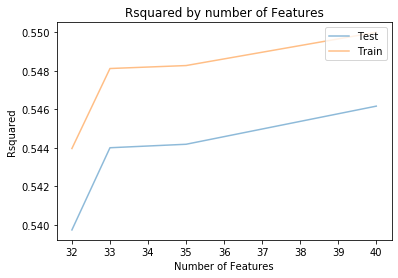

In [34]:
# cutoffs here pertains to the number of missing values allowed in the used features.
# lower values for cutoffs provides more predictors in the model.
cut_offs =   [3500, 2500, 1000, 100, 50, 30, 25, 20]
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = train(X, y, cut_offs)

In [35]:
print(X.shape[1]) # Number of columns in original X
print(X_train.shape[1]) # Number of columns in reduced X
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_train)]) # The model we should implement train_r2

40
40
0.5461692033210008
0.5500063497577539


The results from Linear Regression are very poor. We try a RandomForestRegressor with GridSearchCV to see if we can improve the results without changing anything else.

In [36]:
def train(X, y, test_size = 0.3, rand_state = 42):
    
    
    # Split the data into train, test using sklearn
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = test_size,
                                                       random_state = rand_state)
        
    
    # based on https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    # Number of trees in the random forest
    n_estimators = [100, 200]
    
    # Number of features to consider at every split
    max_features = ['auto']
    
    # Maximum number of levels in tree
    max_depth = [70, 80]
    max_depth.append(None)
    
    # Minimum number of samples to split a node
    min_samples_split = [8, 10]
    
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [5]
    
    # Method of selecting samples for training each tree
    bootstrap = [True]
    
    # Create the hyperparameters grid 
    param_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }
    
    # Create a base model
    base_model = RandomForestRegressor(random_state = rand_state)
    
    # Instantiate the Grid Search Model
    grid_search = GridSearchCV(estimator = base_model, 
                               param_grid = param_grid,
                              cv = 3,
                              n_jobs = -1,
                              verbose = 10)
    
    # Fit the grid search to our data
    grid_search.fit(X_train, y_train)
    
    # Our tuned model here
    rf_model = grid_search.best_estimator_
    
    # Predict using the model
    y_test_preds = rf_model.predict(X_test)
    y_train_preds = rf_model.predict(X_train)
    
    # compute the r2_scores 
    r2_scores_test = r2_score(y_test, y_test_preds)
    r2_scores_train = r2_score(y_train, y_train_preds)
    
    return r2_scores_test, r2_scores_train, rf_model, X_train, X_test, y_train, y_test

In [37]:
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = train(X, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 303.4min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed: 331.1min remaining: 145.7min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 356.9min remaining: 86.1min
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed: 358.6min remaining: 32.6min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 375.9min finished


In [79]:
print('[ info ] R^2 scores test: {} R^2 scores train {}'.format(r2_scores_test, r2_scores_train))

[ info ] R^2 scores test: 0.9878160211121585 R^2 scores train 0.9882146520921514


## Linear Regression Model versus Random Forest Regressor
1. First we see that both models are not overfitting because the R^2 on the training and test datasets are marginally different, with the Random Forest even more marginal that the Linear Regressor.
2. The Random Forest Regressor nearly twice outperforms the Linear Regressor proving that its better suited to this dataset.
3. The Random Forest Regressor is therefore more superior and better at predicting the price of AirBnB accomodation in Seattle.
4. The Linear Regressor, while producing poor results, is quite quick computationally as compared to the Random Forest which took hours to tweak with the final model being produced in 6 hours.

In [74]:
df_train = X.copy()
df_train['price'] = y

In [75]:
df_train.head()

,host_listings_count,accommodates,bathrooms,bedrooms,beds,extra_people,number_of_reviews,review_scores_rating,host_response_time_within a day,host_response_time_within a few hours,...,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict,price
0,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,1,1,0,85.0
1,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,1,1,0,85.0
2,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,1,1,0,85.0
3,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,1,1,0,85.0
4,3.0,4,1.0,1.0,1.0,5.0,207,95.0,0,1,...,0,0,0,0,0,0,1,1,0,85.0


In [80]:
X_train.columns

Index(['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'extra_people', 'number_of_reviews', 'review_scores_rating',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_acceptance_rate_100%',
       'host_is_superhost_t', 'host_identity_verified_t',
       'city_Phinney Ridge Seattle', 'city_Seattle', 'city_West Seattle',
       'property_type_Bed & Breakfast', 'property_type_Boat',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Dorm',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Tent', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Yurt',
       'room_type_Private room', 'room_type_Shared room', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_

## Feature Importance
Lets see which factors or variables our RandomForestRegressor says drives the price of AirBnB accomodation.

In [176]:
importances = lm_model.feature_importances_ * 100
std = np.std([tree.feature_importances_ for tree in lm_model.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
# Feature ranking
print('[ info ] Feature ranking ...')
for f in range(X_train.shape[1]):
    print('%d. %s: (%f)' % (f + 1, X_train.columns[indices[f]] ,importances[indices[f]]))

[ info ] Feature ranking ...
1. bedrooms: (36.766204)
2. accommodates: (12.954024)
3. bathrooms: (7.708095)
4. number_of_reviews: (7.312775)
5. extra_people: (5.149953)
6. host_listings_count: (4.315531)
7. beds: (3.493740)
8. review_scores_rating: (3.360170)
9. room_type_Private room: (3.058988)
10. cancellation_policy_strict: (1.734147)
11. room_type_Shared room: (1.719883)
12. host_response_time_within an hour: (1.715339)
13. cancellation_policy_moderate: (1.711321)
14. host_identity_verified_t: (1.595102)
15. property_type_House: (1.356062)
16. property_type_Boat: (1.325507)
17. host_response_time_within a few hours: (1.178328)
18. property_type_Condominium: (0.991397)
19. host_response_time_within a day: (0.893008)
20. host_is_superhost_t: (0.505589)
21. property_type_Loft: (0.347000)
22. property_type_Townhouse: (0.222975)
23. property_type_Bed & Breakfast: (0.186160)
24. property_type_Camper/RV: (0.172929)
25. bed_type_Real Bed: (0.070718)
26. property_type_Cabin: (0.039262)
27.

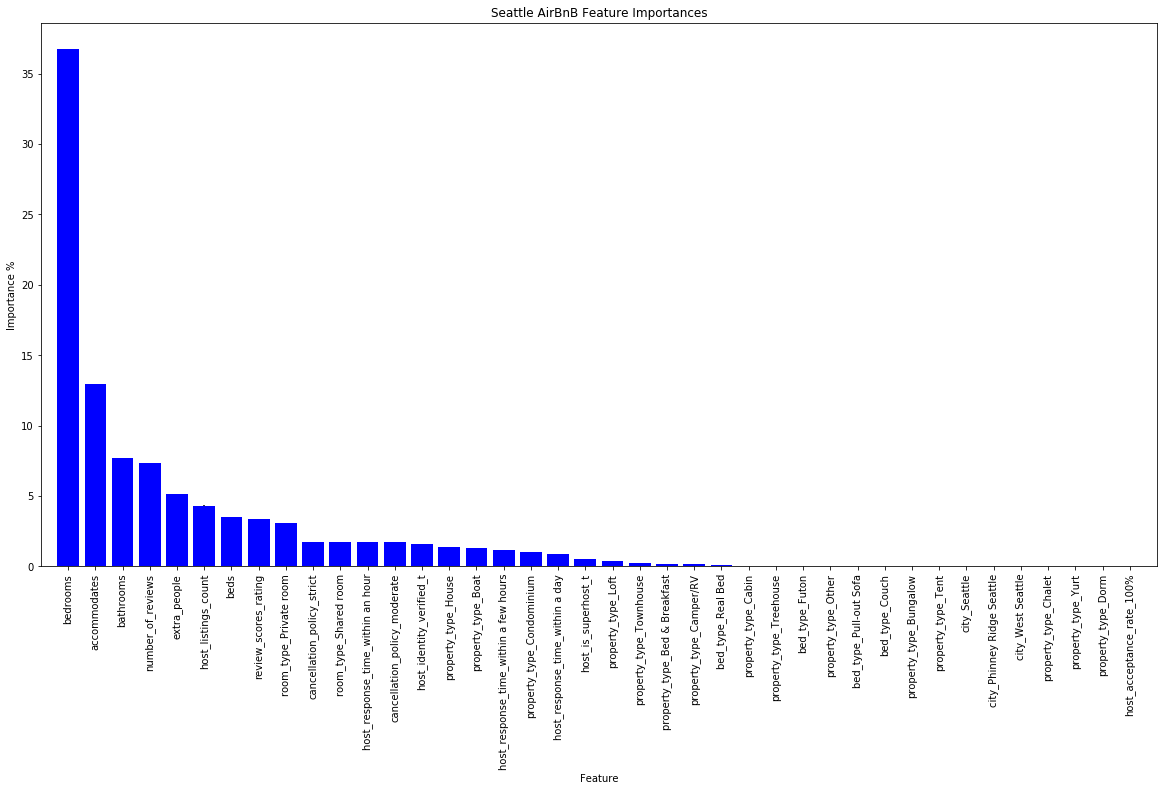

In [178]:
# Lets plot the feature importances
plt.figure(figsize = (20, 10))
plt.title('Seattle AirBnB Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], 
        color = 'b', yerr = std[indices], align = 'center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation = 'vertical')
plt.ylabel('Importance %')
plt.xlabel('Feature')
plt.xlim(-1, X.shape[1])
plt.show()

Our plot above shows the feature importances in red along with their inter-trees variability. The first nine, of the forty, features as above drives the prices of accomodation in Seattle.

This is consistent with our intuitions as we anecdotally expect accomodation with more bedrooms, accommodates more people, have more bath rooms for those people and charges more for extra people to be more expensive.

The key insight here is that a simple strategy to minimize cost is to take a minimalist view on the above nine features. The more you can squeeze into fewer bedrooms, bathrooms, the better. All other features contribute marginally to the price of accomodation.

Lets see what our heatmap says about these features with relation to price.

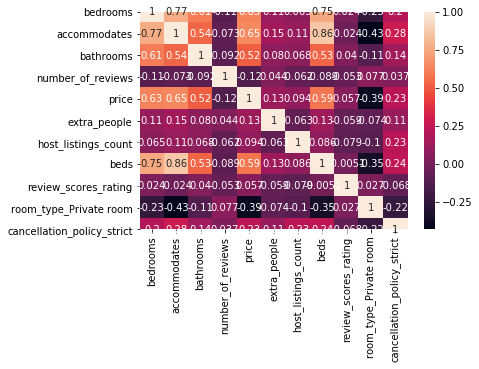

In [90]:
core_cols = ['bedrooms', 'accommodates', 'bathrooms', 
             'number_of_reviews', 'price', 'extra_people', 'host_listings_count',
            'beds', 'review_scores_rating', 'room_type_Private room', 'cancellation_policy_strict']
sns.heatmap(df_train[core_cols].corr(), annot = True)

Comparing our feature importances to the above heatmap suggests that our model is consistent with the way different features correlate with price. All our features highlighted as important show some degree of correlation with price. 
There are minor differences though, for example, the number of people that can be accomodated has the highest correlation with price while the number of bedrooms has the highest impact in our model. 
We also see that there is high correlation between bedrooms and accomodates suggesting that these two features move together.

## Analysis of growth and demand for AirBnB accomodation in Seattle.

In [122]:
cal_df.head()

,listing_id,date,available,price,year,month
0,241032,2016-01-04,t,$85.00,2016,1
1,241032,2016-01-05,t,$85.00,2016,1
9,241032,2016-01-13,t,$85.00,2016,1
10,241032,2016-01-14,t,$85.00,2016,1
14,241032,2016-01-18,t,$85.00,2016,1


In [124]:
print(cal_df['date'].min(), cal_df['date'].max())

2016-01-04 00:00:00 2017-01-02 00:00:00


In [128]:
fill_zeros = lambda x: str(x).zfill(2)

In [131]:
cal_df['month'] = cal_df['month'].apply(fill_zeros)

In [136]:
cal_df['year_month'] = cal_df['year'].astype(str) + cal_df['month']
cal_df.head()

,listing_id,date,available,price,year,month,year_month
0,241032,2016-01-04,t,$85.00,2016,01,201601
1,241032,2016-01-05,t,$85.00,2016,01,201601
9,241032,2016-01-13,t,$85.00,2016,01,201601
10,241032,2016-01-14,t,$85.00,2016,01,201601
14,241032,2016-01-18,t,$85.00,2016,01,201601


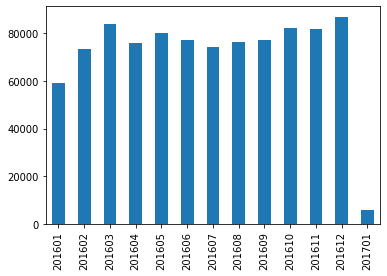

In [150]:
demand_per_month_df = cal_df['year_month'].astype(int).value_counts().sort_index().plot(kind='bar')
demand_per_month_df

We see that demand increased steadily from July-2016 to Dec-2016. We cant establish if demand is cyclical from this data since we have only year's data. However based on this plot we can conclude that demand for AirBnB accomodation is increasing.

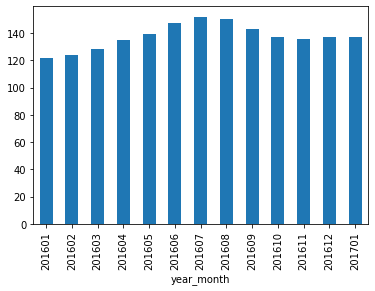

In [161]:
remove_dollar = lambda x: x.strip('$')
remove_comma = lambda x: x.replace(',','')
cal_df['price'] = cal_df['price'].apply(remove_dollar)
cal_df['price'] = cal_df['price'].apply(remove_comma)
cal_df['price'] = cal_df['price'].astype(float)

cal_df.groupby('year_month')['price'].mean().plot(kind = 'bar')

We see that prices rise in June, July, August and September which are also the warmest (summer) months in Seattle. The coldest months (Jan, Feb, Nov and Dec) have relatively lower prices. We can conclude that bargains are likely to be found during these times.

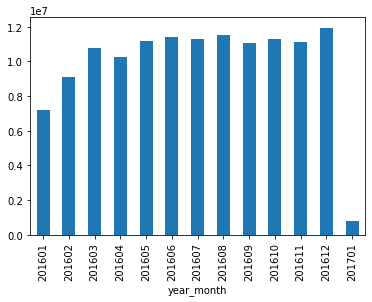

In [162]:
cal_df.groupby('year_month')['price'].sum().plot(kind = 'bar')

This plot also shows that not only are AirBnB revenues increasing overall but also that low number of listings in June, July and August are balanced by high higher prices thats we dont see a revenue drop during those months.

### 6. Results and Recommendations

The key results and recommendations which answer our business questions are as follows:
- We built two models for predicting prices of AirBnB accomodation in Seattle. We found that the Random Forest model produced the better results and predictive capabilities.
- Based on our model we identified that the top nine variables that drive price are bedrooms, accommodates, bathrooms, number_of_reviews, extra_people, host_listings_count, beds, review_scores_rating and room_type_Private room.
- Armed with the above information we can predict the price of accomodation with a 98% accuracy.
- We also found that prices can be reduced by reduced the number of bedrooms, the number of people that can be accomodated, bathrooms and looking at the price for extra people.
- Prices can further be reduced by potentially carefully chosing the time of the year to visit Seattle. Prices are very high in the summer months.
- Although prices are set by owners of accomodation they are actually following basic microecomic principles. For example, prices are high during the hot months in Seattle when they are fewer properties available.
- We found that the demand for AirBnB accomodation has overall been increasing and growing which is good for both renters and stayers.

### 7. Deployment

Our model can now be deployed in the cloud as a web service which can be consumed by mobile applications and websites. These clients will need to provide a basic interface where a user can query for prices by any of the variables identified above as price drivers and also see plots to show price movements and demand during the year.